#1. PCA on Images

In [ ]:

import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("Original training data shape:", x_train.shape)
print("Original test data shape:", x_test.shape)

x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

print("\nNormalized training data min/max:", x_train_normalized.min(), x_train_normalized.max())
print("Normalized test data min/max:", x_test_normalized.min(), x_test_normalized.max())

mean_pixel = np.mean(x_train_normalized, axis=(0, 1, 2))

x_train_centered = x_train_normalized - mean_pixel
x_test_centered = x_test_normalized - mean_pixel

print("\nCentered training data mean (approx 0):", np.mean(x_train_centered))
print("Centered test data mean (approx 0):", np.mean(x_test_centered))

print("\nData loading, normalization, and centering complete.")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Original training data shape: (50000, 32, 32, 3)
Original test data shape: (10000, 32, 32, 3)

Normalized training data min/max: 0.0 1.0
Normalized test data min/max: 0.0 1.0

Centered training data mean (approx 0): -5.3886095e-07
Centered test data mean (approx 0): 0.003221372

Data loading, normalization, and centering complete.


In [ ]:
import tensorflow as tf
import numpy as np
import kagglehub
import pathlib
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
data_path = pathlib.Path(path)

data_dir = data_path / "lfw-deepfunneled" / "lfw-deepfunneled"
if not data_dir.exists():
    data_dir = data_path / "lfw" / "lfw"

IMG_SIZE = 64
BATCH_SIZE = 64

print(f"\nLoading images at {IMG_SIZE}x{IMG_SIZE}...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='int',
    verbose=1
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='int',
    verbose=1
)

faces_train = np.concatenate([x for x, y in train_ds], axis=0)
faces_test = np.concatenate([x for x, y in test_ds], axis=0)

#normalize to [0,1]
x_train_norm = faces_train.astype('float32') / 255.0
x_test_norm = faces_test.astype('float32') / 255.0

print(f"\nData Loaded. Feature count per image: {IMG_SIZE*IMG_SIZE*3}")


Using Colab cache for faster access to the 'lfw-dataset' dataset.

Loading images at 64x64...
Found 13233 files belonging to 5749 classes.
Using 10587 files for training.
Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.

Data Loaded. Feature count per image: 12288


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict

def flatten_images(X: np.ndarray):
    """Flatten images from (N, H, W, C) -> (N, D) where D = H*W*C."""
    return X.reshape(X.shape[0], -1)

def center_data(X: np.ndarray, mean: np.ndarray = None):
    """
    Center data by subtracting mean across samples.
    Returns (X_centered, mean).
    """
    if mean is None:
        mean = X.mean(axis=0)
    Xc = X - mean
    return Xc, mean

def standardize_data(X: np.ndarray, std: np.ndarray = None):
    """
    Standardize features to unit variance (per column).
    Returns (X_std, std).
    """
    if std is None:
        std = X.std(axis=0)
        # avoid division by zero
        std[std == 0] = 1.0
    Xs = X / std
    return Xs, std

def compute_covariance_matrix(X_centered: np.ndarray):
    """
    Compute covariance matrix Σ = (1 / (n-1)) * X^T X
    where X_centered is (n_samples, n_features).
    """
    n = X_centered.shape[0]
    cov = (X_centered.T @ X_centered) / (n - 1)
    return cov

def compute_correlation_matrix(X_centered: np.ndarray):
    """
    Compute correlation matrix from centered data: Corr = D^{-1/2} Cov D^{-1/2}
    """
    std = X_centered.std(axis=0)
    std[std == 0] = 1.0
    Xs = X_centered / std
    return compute_covariance_matrix(Xs)

def eigen_decomposition(S: np.ndarray):
    """
    Eigenvalue decomposition for symmetric matrix S.
    Returns eigenvalues (descending) and corresponding eigenvectors.
    """
    # eigh returns eigenvalues in ascending order; flip to descending
    eigvals, eigvecs = np.linalg.eigh(S)
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    return eigvals, eigvecs

def explained_variance_ratio(eigvals: np.ndarray):
    """Return the explained variance ratio per principal component."""
    total = eigvals.sum()
    return eigvals / total

def project_data(X_centered: np.ndarray, eigvecs: np.ndarray, k: int):
    """
    Project centered data onto the first k eigenvectors (principal components).
    X_centered: (n_samples, n_features)
    eigvecs: (n_features, n_features) with eigenvectors as columns
    returns projected data Z (n_samples, k)
    """
    Wk = eigvecs[:, :k]  # (n_features, k)
    Z = X_centered @ Wk  # (n_samples, k)
    return Z

def reconstruct_from_components(Z: np.ndarray, eigvecs: np.ndarray, k: int, mean: np.ndarray):
    """
    Reconstruct approximate X from projected Z (n_samples, k) using top-k eigenvectors.
    Returns reconstructed in original feature space (n_samples, n_features).
    """
    Wk = eigvecs[:, :k]  # (n_features, k)
    X_approx_centered = Z @ Wk.T  # (n_samples, n_features)
    X_approx = X_approx_centered + mean
    return X_approx

def find_n_components_for_thresholds(eigvals: np.ndarray, thresholds=[0.90, 0.95, 0.99]):
    """
    Given eigenvalues sorted descending, find minimal k for each cumulative threshold.
    """
    ratios = explained_variance_ratio(eigvals)
    cumulative = np.cumsum(ratios)
    result = {}
    for t in thresholds:
        k = int(np.searchsorted(cumulative, t) + 1)
        result[t] = k
    return result

def mse(original: np.ndarray, reconstructed: np.ndarray):
    return np.mean((original - reconstructed) ** 2)

def frobenius_norm(original: np.ndarray, reconstructed: np.ndarray):
    diff = original - reconstructed
    return np.linalg.norm(diff, ord='fro')

def run_pca_pipeline(x_train_normalized, x_test_normalized, sample_size: int = None, plot=True):
    X_train = flatten_images(x_train_normalized)
    X_test = flatten_images(x_test_normalized)

    if sample_size is not None and sample_size < X_train.shape[0]:
        rng = np.random.default_rng(123)
        idx = rng.choice(X_train.shape[0], size=sample_size, replace=False)
        X_train_sample = X_train[idx]
    else:
        X_train_sample = X_train

    print("Train shape (flattened):", X_train_sample.shape)

    X_train_centered, train_mean = center_data(X_train_sample, None)
    X_test_centered = X_test - train_mean

    print("Computing covariance matrix...")
    Cov = compute_covariance_matrix(X_train_centered)
    eigvals_cov, eigvecs_cov = eigen_decomposition(Cov)
    cum_cov = np.cumsum(explained_variance_ratio(eigvals_cov))

    print("Computing correlation matrix...")
    std_feat = X_train_sample.std(axis=0)
    std_feat[std_feat == 0] = 1.0
    X_train_std = (X_train_sample - train_mean) / std_feat
    Corr = compute_covariance_matrix(X_train_std)
    eigvals_corr, eigvecs_corr = eigen_decomposition(Corr)
    cum_corr = np.cumsum(explained_variance_ratio(eigvals_corr))

    thresholds = [0.90, 0.95, 0.99]
    km_cov = find_n_components_for_thresholds(eigvals_cov, thresholds)
    km_corr = find_n_components_for_thresholds(eigvals_corr, thresholds)

    print(f"Components needed (Cov): {km_cov}")
    print(f"Components needed (Corr): {km_corr}")

    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(np.arange(1, len(cum_cov)+1), cum_cov, label='Covariance')
        for t in thresholds:
            plt.axhline(t, color='k', linestyle='--', linewidth=0.6)
            plt.text(5, t + 0.01, f"{int(t*100)}% -> k={km_cov[t]}", fontsize=8)
        plt.title("Covariance PCA Variance")
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(np.arange(1, len(cum_corr)+1), cum_corr, label='Correlation')
        for t in thresholds:
            plt.axhline(t, color='k', linestyle='--', linewidth=0.6)
            plt.text(5, t + 0.01, f"{int(t*100)}% -> k={km_corr[t]}", fontsize=8)
        plt.title("Correlation PCA Variance")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    results = {'covariance': {}, 'correlation': {}}

    X_test_centered_full = X_test - train_mean
    std_feat_full = std_feat
    X_test_full_std = (X_test - train_mean) / std_feat_full

    for t in thresholds:
        k_cov = km_cov[t]
        k_corr = km_corr[t]

        Z_test_cov = project_data(X_test_centered_full, eigvecs_cov, k_cov)
        X_test_cov_recon = reconstruct_from_components(Z_test_cov, eigvecs_cov, k_cov, train_mean)

        Z_test_corr = project_data(X_test_full_std, eigvecs_corr, k_corr)
        X_test_corr_recon_std = reconstruct_from_components(Z_test_corr, eigvecs_corr, k_corr, mean=np.zeros(train_mean.shape))
        X_test_corr_recon = X_test_corr_recon_std * std_feat_full + train_mean

        results['covariance'][t] = {'k': k_cov, 'mse': mse(X_test, X_test_cov_recon)}
        results['correlation'][t] = {'k': k_corr, 'mse': mse(X_test, X_test_corr_recon)}

        if plot:
            n_features = X_test.shape[1]
            img_side = int(np.sqrt(n_features // 3))
            img_shape = (img_side, img_side, 3)

            n_show = 3
            fig, axes = plt.subplots(2, n_show, figsize=(n_show*3, 5))

            for i in range(n_show):
                orig = X_test[i].reshape(img_shape)
                recon_cov_img = np.clip(X_test_cov_recon[i].reshape(img_shape), 0, 1)

                axes[0, i].imshow(orig)
                axes[0, i].set_title("Original")
                axes[0, i].axis('off')

                axes[1, i].imshow(recon_cov_img)
                axes[1, i].set_title(f"Cov k={k_cov}")
                axes[1, i].axis('off')

            plt.suptitle(f"Reconstructions at {int(t*100)}% Variance")
            plt.tight_layout()
            plt.show()

    return results

Train shape (flattened): (10000, 3072)
Computing covariance matrix...
Computing correlation matrix...
Components needed (Cov): {0.9: 98, 0.95: 212, 0.99: 630}
Components needed (Corr): {0.9: 101, 0.95: 215, 0.99: 633}


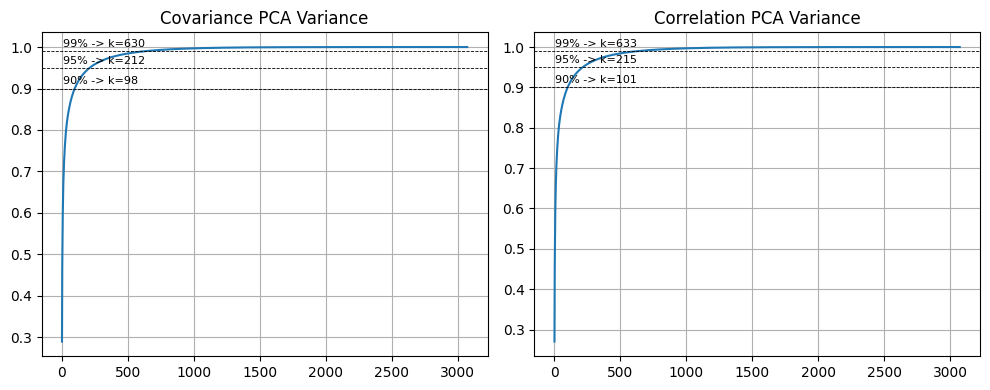

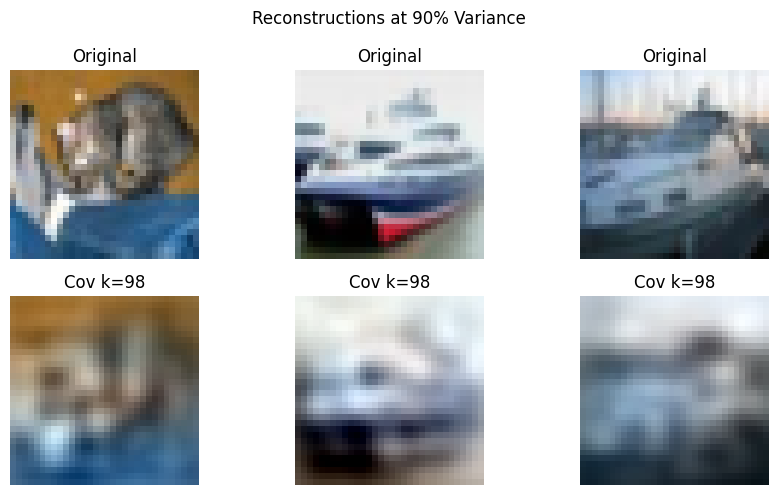

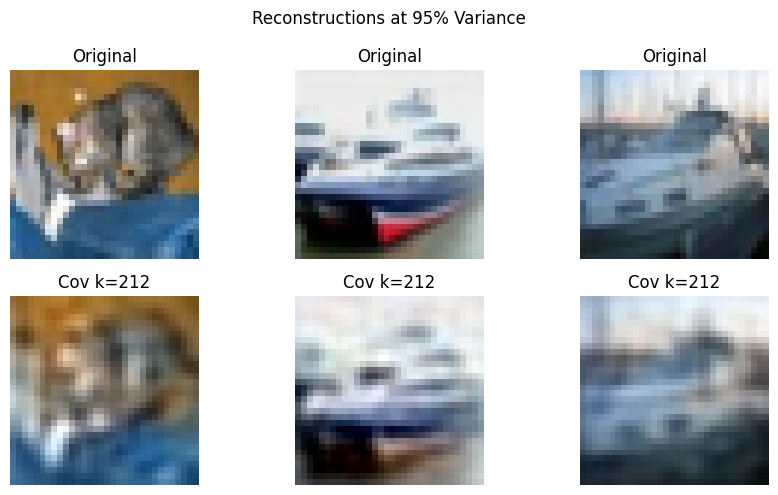

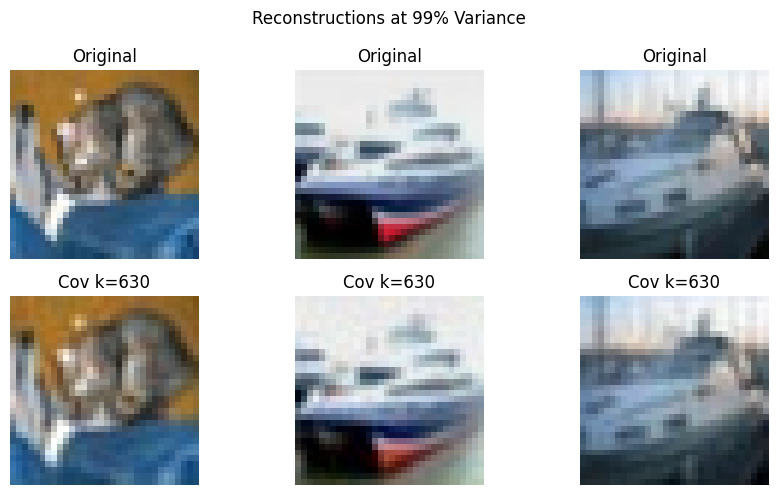

In [ ]:
result = run_pca_pipeline(x_train_normalized, x_test_normalized, sample_size=10000, plot=True)

In [ ]:
print(result)

{'covariance': {0.9: {'k': 98, 'mse': np.float32(0.006327299)}, 0.95: {'k': 212, 'mse': np.float32(0.0032962644)}, 0.99: {'k': 630, 'mse': np.float32(0.000766465)}}, 'correlation': {0.9: {'k': 101, 'mse': np.float64(0.006213479901423994)}, 0.95: {'k': 215, 'mse': np.float64(0.0032639816070759164)}, 0.99: {'k': 633, 'mse': np.float64(0.0007653209580587477)}}}


Train shape (flattened): (10587, 12288)
Computing covariance matrix...
Computing correlation matrix...
Components needed (Cov): {0.9: 268, 0.95: 654, 0.99: 2169}
Components needed (Corr): {0.9: 300, 0.95: 715, 0.99: 2252}


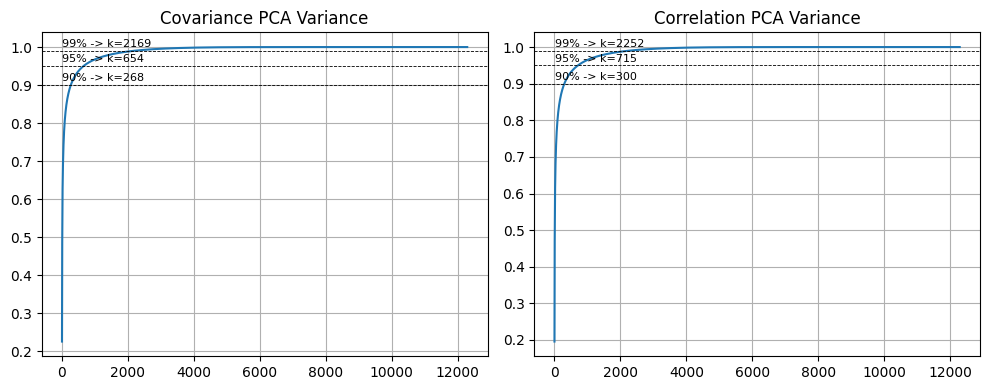

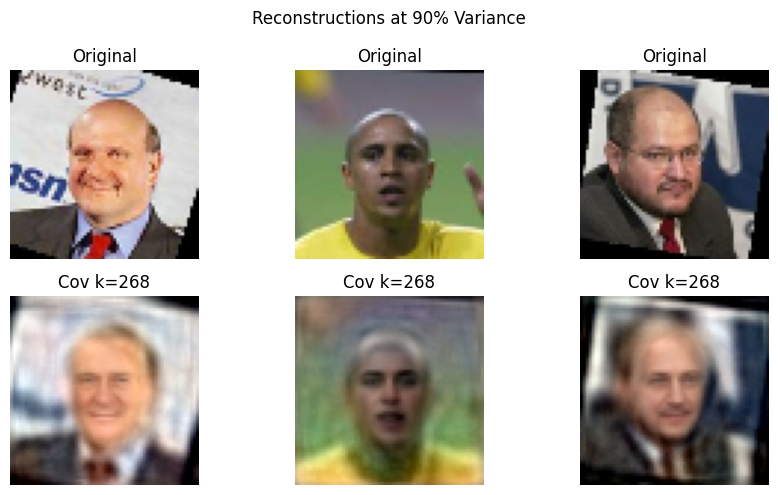

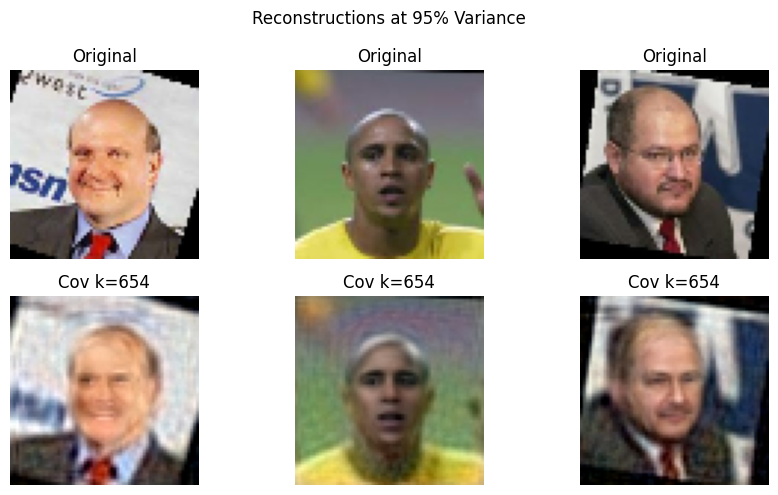

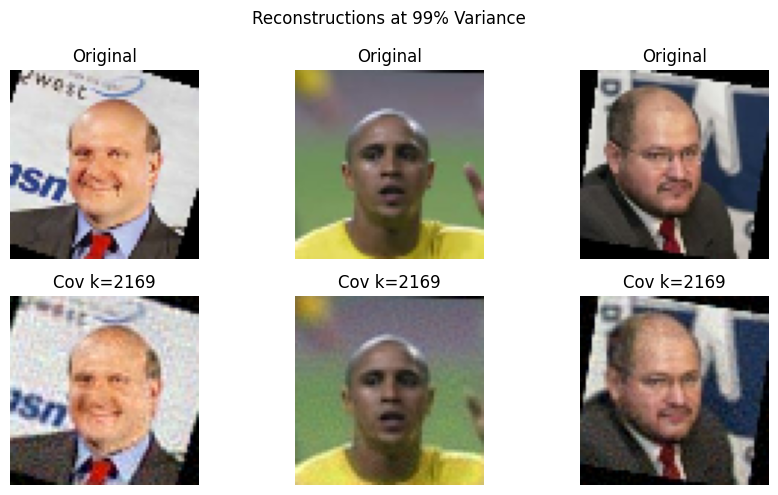

In [ ]:
results = run_pca_pipeline(
    x_train_norm,
    x_test_norm,
    sample_size=None,
    plot=True
)

In [ ]:
print(results)

{'covariance': {0.9: {'k': 268, 'mse': np.float32(0.007600069)}, 0.95: {'k': 654, 'mse': np.float32(0.004258401)}, 0.99: {'k': 2169, 'mse': np.float32(0.0013877207)}}, 'correlation': {0.9: {'k': 300, 'mse': np.float64(0.007346197989824131)}, 0.95: {'k': 715, 'mse': np.float64(0.004168662241990994)}, 0.99: {'k': 2252, 'mse': np.float64(0.0014074717571740372)}}}


#2. PCA on Text

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict

def center_data(X: np.ndarray, mean: np.ndarray = None):
    if mean is None:
        mean = X.mean(axis=0)
    Xc = X - mean
    return Xc, mean

def standardize_data(X: np.ndarray, std: np.ndarray = None):
    if std is None:
        std = X.std(axis=0)
        std[std == 0] = 1.0
    Xs = X / std
    return Xs, std

def compute_covariance_matrix(X_centered: np.ndarray):
    n = X_centered.shape[0]
    # (n-1) for sample covariance
    cov = (X_centered.T @ X_centered) / (n - 1)
    return cov

def eigen_decomposition(S: np.ndarray):
    eigvals, eigvecs = np.linalg.eigh(S)
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    return eigvals, eigvecs

def explained_variance_ratio(eigvals: np.ndarray):
    total = eigvals.sum()
    return eigvals / total

def project_data(X_centered: np.ndarray, eigvecs: np.ndarray, k: int):
    Wk = eigvecs[:, :k]
    Z = X_centered @ Wk
    return Z

def reconstruct_from_components(Z: np.ndarray, eigvecs: np.ndarray, k: int, mean: np.ndarray):
    Wk = eigvecs[:, :k]
    X_approx_centered = Z @ Wk.T
    X_approx = X_approx_centered + mean
    return X_approx

def find_n_components_for_thresholds(eigvals: np.ndarray, thresholds=[0.90, 0.95, 0.99]):
    ratios = explained_variance_ratio(eigvals)
    cumulative = np.cumsum(ratios)
    result = {}
    for t in thresholds:
        k = int(np.searchsorted(cumulative, t) + 1)
        result[t] = k
    return result

def mse(original: np.ndarray, reconstructed: np.ndarray):
    return np.mean((original - reconstructed) ** 2)




In [ ]:
def run_numeric_pca_pipeline(X_train, X_test, feature_names, plot=True):
    print(f"Original Feature Count: {X_train.shape[1]}")

    X_train_centered, train_mean = center_data(X_train)
    X_test_centered = X_test - train_mean

    std_feat = X_train.std(axis=0)
    std_feat[std_feat == 0] = 1.0

    X_train_std = X_train_centered / std_feat
    X_test_std = X_test_centered / std_feat

    print("Computing matrices...")
    Cov = compute_covariance_matrix(X_train_centered)
    Corr = compute_covariance_matrix(X_train_std)

    eigvals_cov, eigvecs_cov = eigen_decomposition(Cov)
    eigvals_corr, eigvecs_corr = eigen_decomposition(Corr)

    cum_cov = np.cumsum(explained_variance_ratio(eigvals_cov))
    cum_corr = np.cumsum(explained_variance_ratio(eigvals_corr))

    thresholds = [0.90, 0.95, 0.99]
    km_cov = find_n_components_for_thresholds(eigvals_cov, thresholds)
    km_corr = find_n_components_for_thresholds(eigvals_corr, thresholds)

    sample_idx = 0
    sample_original = X_test[sample_idx]

    df_display = pd.DataFrame({
        "Feature": feature_names,
        "Original": sample_original
    })

    for t in thresholds:
        k_cv = km_cov[t]
        k_cr = km_corr[t]

        Z_test_cov = project_data(X_test_centered, eigvecs_cov, k_cv)
        X_test_recon_cov = reconstruct_from_components(Z_test_cov, eigvecs_cov, k_cv, train_mean)

        Z_test_corr = project_data(X_test_std, eigvecs_corr, k_cr)
        X_test_recon_corr_std = reconstruct_from_components(Z_test_corr, eigvecs_corr, k_cr, mean=np.zeros_like(train_mean))
        X_test_recon_corr = (X_test_recon_corr_std * std_feat) + train_mean

        df_display[f'Cov_{int(t*100)}% (k={k_cv})'] = X_test_recon_cov[sample_idx]
        df_display[f'Corr_{int(t*100)}% (k={k_cr})'] = X_test_recon_corr[sample_idx]

    if plot:
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(cum_cov)+1), cum_cov, 'o-', label='Covariance (Raw)')
        plt.plot(range(1, len(cum_corr)+1), cum_corr, 's-', label='Correlation (Std)')
        for t in thresholds:
            plt.axhline(t, color='red', linestyle='--', alpha=0.3)
            plt.text(5, t + 0.01, f"{int(t*100)}% -> k={km_corr[t]}", fontsize=8)
        plt.xlabel("Components")
        plt.ylabel("Cumulative Variance")
        plt.title("Variance Explained")
        plt.legend()
        plt.grid(True)

        t_plot = 0.95
        k_cv_plot = km_cov[t_plot]
        k_cr_plot = km_corr[t_plot]

        Z_cov_full = project_data(X_test_centered, eigvecs_cov, k_cv_plot)
        Rec_cov_full = reconstruct_from_components(Z_cov_full, eigvecs_cov, k_cv_plot, train_mean)

        Z_corr_full = project_data(X_test_std, eigvecs_corr, k_cr_plot)
        Rec_corr_std_full = reconstruct_from_components(Z_corr_full, eigvecs_corr, k_cr_plot, np.zeros_like(train_mean))
        Rec_corr_full = (Rec_corr_std_full * std_feat) + train_mean

        plt.subplot(1, 2, 2)
        subset = 50
        plt.plot(X_test[:subset, 0], 'g-', label='Original', linewidth=2)
        plt.plot(Rec_cov_full[:subset, 0], 'r--', label=f'Covariance (k={k_cv_plot})')
        plt.plot(Rec_corr_full[:subset, 0], 'b--', label=f'Correlation (k={k_cr_plot})')
        plt.title("Reconstruction of 'MedInc' (First 50 samples)")
        plt.ylabel("Median Income")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    print("\n" + "="*80)
    print(f"COMPRESSION RECONSTRUCTION (Test Sample #{sample_idx})")
    print("="*80)
    cols = ['Feature', 'Original']
    for t in thresholds:
        cols.append(f'Cov_{int(t*100)}% (k={km_cov[t]})')
    for t in thresholds:
        cols.append(f'Corr_{int(t*100)}% (k={km_corr[t]})')

    print(df_display[cols].round(2).to_string(index=False))

Original Feature Count: 8
Computing matrices...


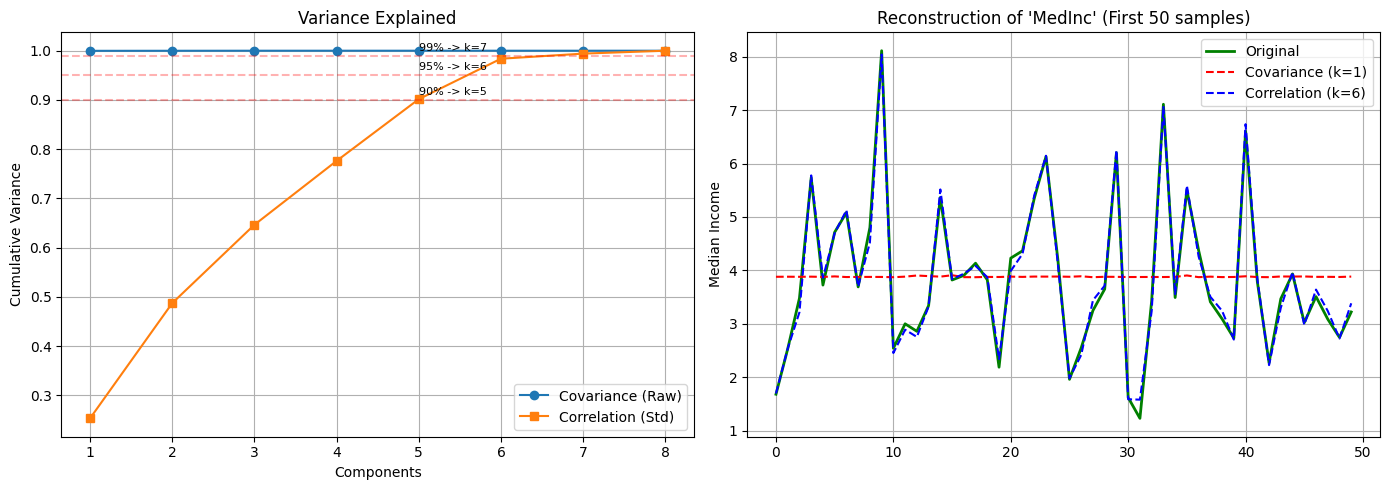


COMPRESSION RECONSTRUCTION (Test Sample #0)
   Feature  Original  Cov_90% (k=1)  Cov_95% (k=1)  Cov_99% (k=1)  Corr_90% (k=5)  Corr_95% (k=6)  Corr_99% (k=7)
    MedInc      1.68           3.88           3.88           3.88            1.83            1.70            1.62
  HouseAge     25.00          28.72          28.72          28.72           29.02           24.72           24.91
  AveRooms      4.19           5.44           5.44           5.44            4.19            4.06            4.33
 AveBedrms      1.02           1.10           1.10           1.10            1.07            1.05            1.00
Population   1392.00        1392.01        1392.01        1392.01         1764.00         1383.20         1389.59
  AveOccup      3.88           3.07           3.07           3.07            2.86            3.90            3.89
  Latitude     36.06          35.65          35.65          35.65           35.66           35.71           35.89
 Longitude   -119.01        -119.59        

In [ ]:
housing = fetch_california_housing()
X = housing.data
y = housing.target
feature_names = housing.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

run_numeric_pca_pipeline(X_train, X_test, feature_names)